In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Pre processing

We first import the data and clean it, removing spaces in class names or putting everything to uppercase. We also test if there is any null value and map the classes to binary values.

In [47]:
db = pd.read_csv("diabetes_dataset.csv")
print("size:", db.shape)
db.head()

size: (1000, 14)


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [48]:
print("Class before:", db['CLASS'].unique())
db['CLASS'] = db['CLASS'].str.strip()
db['CLASS'].unique()

Class before: ['N' 'N ' 'P' 'Y' 'Y ']


array(['N', 'P', 'Y'], dtype=object)

In [49]:
print("Class before:", db['Gender'].unique())
db['Gender'] = db['Gender'].str.upper()
db['Gender'].unique()

Class before: ['F' 'M' 'f']


array(['F', 'M'], dtype=object)

In [50]:
db.isna().sum()

ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64

In [51]:
db['Gender'] = db['Gender'].map({'M': 0, 'F': 1})
db['CLASS'] = db["CLASS"].map({'N': 0, 'P': 1, 'Y': 1})

# Smote - Synthetic Minority Over-sampling Technique

Devido a natureza dos dados, a classe minoritaria é infinitamente inferior e precisa ser inflada para compensar a diferença. Para isso utilizamos a técnica de SMOTE para over-sampling sintático da classe minoritária.

In [52]:
class_percentages = db['CLASS'].value_counts(normalize=True) * 100
print(class_percentages)

CLASS
1    89.7
0    10.3
Name: proportion, dtype: float64


In [53]:
x = db.drop("CLASS", axis=1)  # 'class' is the target column
x.drop("No_Pation", axis=1)
x.drop("ID", axis=1)
y = db["CLASS"]

In [54]:
# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print(y_train.value_counts(normalize=True) * 100)

CLASS
1    90.428571
0     9.571429
Name: proportion, dtype: float64


In [84]:
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)
print(y_res.value_counts(normalize=True) * 100)

CLASS
1    50.0
0    50.0
Name: proportion, dtype: float64


# Decision Tree Classifier

Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       1.00      0.99      0.99       264

    accuracy                           0.99       300
   macro avg       0.97      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



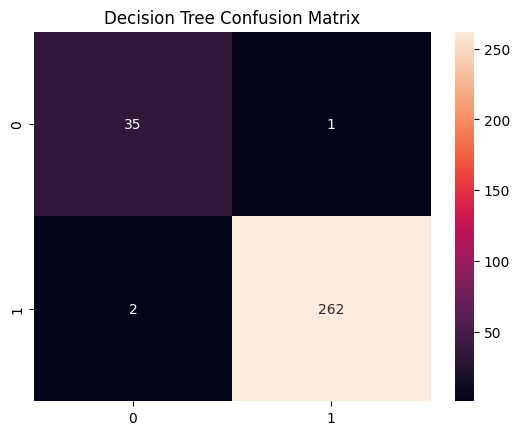

In [73]:
tree_model = tree.DecisionTreeClassifier(random_state=42)
tree_model.fit(x_res, y_res)
tree_preds = tree_model.predict(x_test)

print("Decision Tree:")
print(classification_report(y_test, tree_preds))
sns.heatmap(confusion_matrix(y_test, tree_preds), annot=True, fmt='d')
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [58]:

tree_model.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.9009009 , 0.00841027, 0.03156392, 0.00307641,
       0.00414966, 0.00210637, 0.04979247])

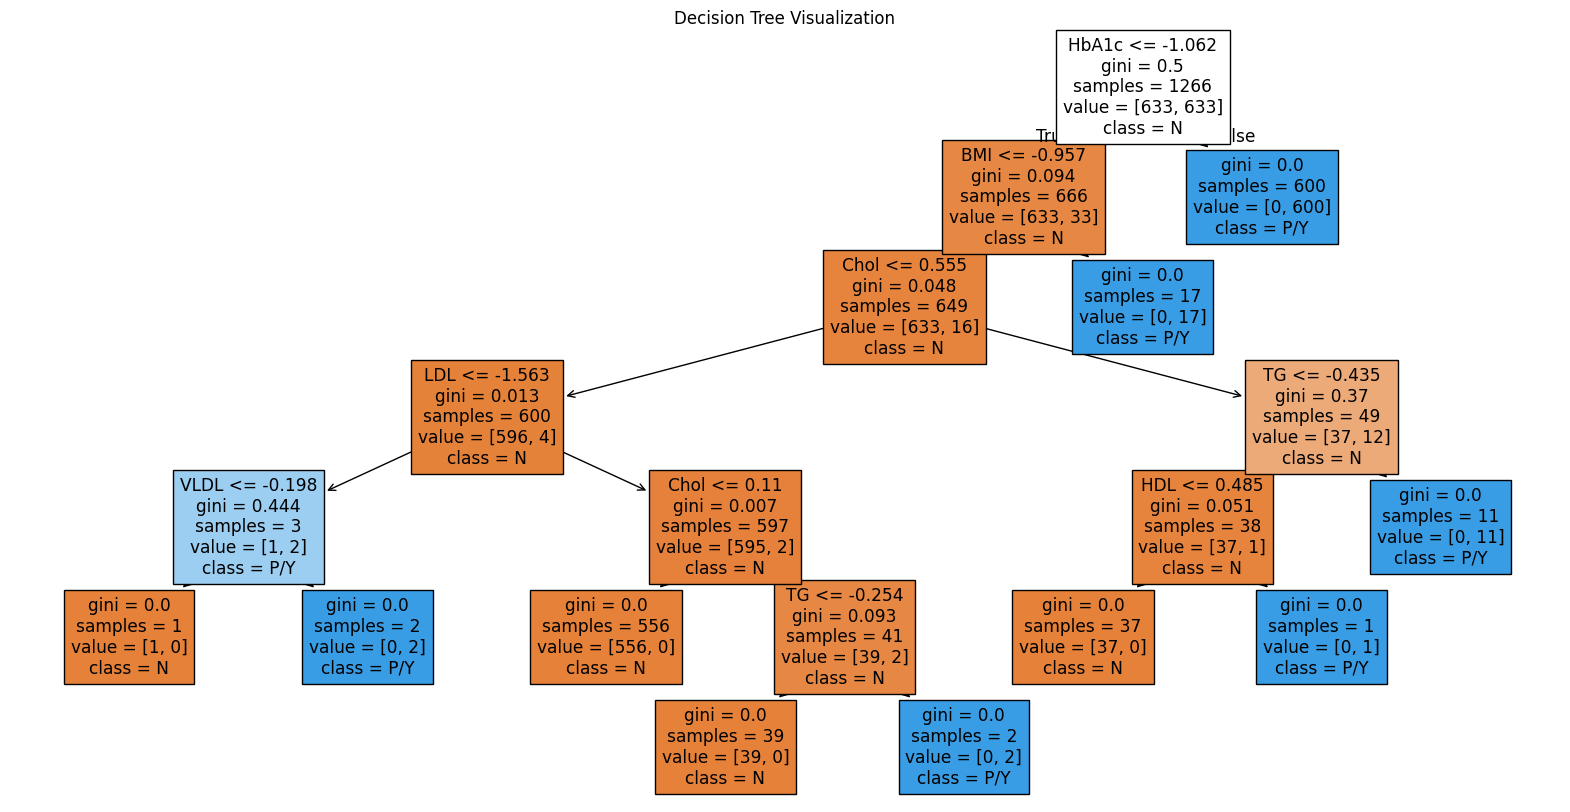

In [59]:
plt.figure(figsize=(20,10))
tree.plot_tree(tree_model, feature_names=list(x.columns), class_names=['N', 'P/Y'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


# K-Nearest Neighboors

In [60]:
# GridSearchCV para encontrar o melhor n_neighbors
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_res, y_res)

best_k = grid_search.best_params_['n_neighbors']
print(f"Melhor valor de n_neighbors encontrado pelo GridSearchCV: {best_k}")

Melhor valor de n_neighbors encontrado pelo GridSearchCV: 3


k-NN:
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        36
           1       0.99      0.94      0.96       264

    accuracy                           0.94       300
   macro avg       0.83      0.94      0.87       300
weighted avg       0.95      0.94      0.94       300



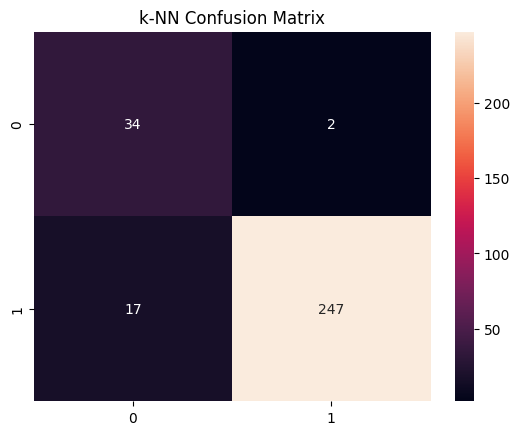

In [95]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_res, y_res)
knn_preds = knn_model.predict(x_test)

print("k-NN:")
print(classification_report(y_test, knn_preds))
sns.heatmap(confusion_matrix(y_test, knn_preds), annot=True, fmt='d')
plt.title("k-NN Confusion Matrix")
plt.show()

# Support Vector Machine

In [96]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(x_res, y_res)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [97]:
clf.best_params_
print("Melhores parâmetros encontrados pelo GridSearchCV:", clf.best_params_)

Melhores parâmetros encontrados pelo GridSearchCV: {'C': 10, 'kernel': 'rbf'}


In [79]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

SVM:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        36
           1       0.98      0.98      0.98       264

    accuracy                           0.96       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.96      0.96      0.96       300



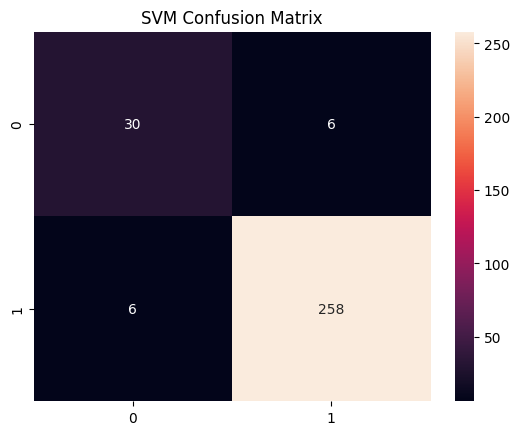

In [98]:
svm_model = SVC(kernel='rbf', C=10, random_state=42)
svm_model.fit(x_res, y_res)
svm_preds = svm_model.predict(x_test)

print("SVM:")
print(classification_report(y_test, svm_preds))
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d')
plt.title("SVM Confusion Matrix")
plt.show()

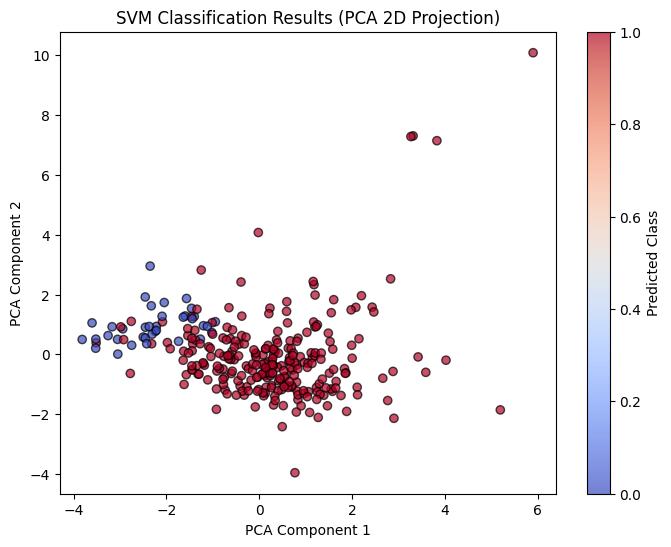

In [100]:
from sklearn.decomposition import PCA

# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(x_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=svm_preds, cmap='coolwarm', alpha=0.7, edgecolor='k')
plt.title("SVM Classification Results (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Predicted Class')
plt.show()

In [101]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

# Choose three features
features = ['HbA1c', 'BMI', 'HDL']
X = db[features].values
y = db['CLASS']
print(y)


0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Name: CLASS, Length: 1000, dtype: int64


# Untested code but supercool

In [102]:

# 2. Train/test split & scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 3. Train SVM on these features
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

# 4. Build a 3D grid
#    Determine min/max in each dimension (with a little padding)
mins = X_train.min(axis=0) - 0.5
maxs = X_train.max(axis=0) + 0.5
#    Define grid resolution
grid_x = np.linspace(mins[0], maxs[0], 30)
grid_y = np.linspace(mins[1], maxs[1], 30)
grid_z = np.linspace(mins[2], maxs[2], 30)
xx, yy, zz = np.meshgrid(grid_x, grid_y, grid_z)

# 5. Evaluate decision function on grid points
grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
decision_vals = svm.decision_function(grid_points)
decision_vals = decision_vals.reshape(xx.shape)

# 6. Plotly 3D Scatter + Isosurface
scatter = go.Scatter3d(
    x = X_test[:,0], y = X_test[:,1], z = X_test[:,2],
    mode='markers',
    marker=dict(
        color=y_test,
        colorscale='Viridis',
        size=4,
        opacity=0.8,
        symbol='circle'
    ),
    name='Test Points'
)

# The isosurface at decision=0 is the decision boundary
surface = go.Isosurface(
    x=xx.flatten(), y=yy.flatten(), z=zz.flatten(),
    value=decision_vals.flatten(),
    isomin=0, isomax=0,
    surface_count=1,
    opacity=0.3,
    showscale=False,
    name='Decision Boundary'
)

layout = go.Layout(
    scene=dict(
        xaxis_title=features[0],
        yaxis_title=features[1],
        zaxis_title=features[2]
    ),
    width=700, height=700
)

fig = go.Figure(data=[scatter, surface], layout=layout)
fig.show()


Made changes.